In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt

In [15]:
df=pd.read_csv("../data/merged/len3_ship_agg_drop_never.csv",encoding="shift-jis",index_col=0)

Estimation

In [16]:
## processing
df_columns = df.columns # 列名をリストとして取得
import re

# 正規表現パターンを作成します
pattern = r'id|^elasped_(m[0-5]|[0-9]|1\d|20)$'

# 列名のリストを作成します
column_names = [col for col in df_columns if re.search(pattern, col)]

# 列名のリストを表示します
print(column_names)
rest_columns=["year","generic_per"]
column_names=rest_columns+column_names
# try:
#     column_names.remove("elasped_m1")
# except:
#     1

try:
    column_names.remove("elasped")
except:
    1
try:
    column_names.remove("id")
except:
    1
try:
    column_names.remove("id_114")
except:
    1
# column_names

['id', 'elasped_m5', 'elasped_m4', 'elasped_m3', 'elasped_m2', 'elasped_m1', 'elasped_0', 'elasped_1', 'elasped_2', 'elasped_3', 'elasped_4', 'elasped_5', 'elasped_6', 'elasped_7', 'elasped_8', 'elasped_9', 'elasped_10', 'elasped_11', 'elasped_12', 'elasped_13', 'elasped_14', 'elasped_15', 'elasped_16', 'elasped_17', 'elasped_18', 'elasped_19', 'elasped_20', 'id_114', 'id_121', 'id_123', 'id_124', 'id_131', 'id_132', 'id_211', 'id_217', 'id_218', 'id_222', 'id_223', 'id_224', 'id_225', 'id_229', 'id_231', 'id_232', 'id_235', 'id_239', 'id_245', 'id_252', 'id_259', 'id_264', 'id_265', 'id_279', 'id_313', 'id_321', 'id_332', 'id_339', 'id_391', 'id_399', 'id_441', 'id_449', 'id_625', 'id_629', 'id_799']


In [17]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_dom"]>0]
df=df.loc[df["rx_dom"]>0]

# make log columns
df["log_rx_dom"]=np.log(df["rx_dom"]+0.001)
df["log_otc_dom"]=np.log(df["otc_dom"]+0.001)
df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"]+0.001)
df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"]+0.001)

In [18]:
df=df.set_index(["id","year"])
df.info()
# make this to paneldata
df=PanelData(df)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 386 entries, (114, 2008) to (799, 2021)
Columns: 109 entries, efficacy to log_stock_otc_lag
dtypes: float64(14), int64(91), object(4)
memory usage: 331.5+ KB


(183, 14, 30)

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

## RX

In [19]:
formula="rx_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"
# stock lag version
formula="rx_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+stock_rx_lagLTimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])

                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
elasped_m5   1.823e+07  6.265e+06     2.9106     0.0038   5.911e+06   3.056e+07
elasped_m4   2.489e+07  1.081e+07     2.3023     0.0219   3.624e+06   4.615e+07
elasped_m3   2.213e+07   1.17e+07     1.8909     0.0595  -8.916e+05   4.514e+07
elasped_m2   2.809e+07  1.699e+07     1.6527     0.0993  -5.343e+06   6.152e+07
elasped_0     2.29e+07  1.701e+07     1.3465     0.1791  -1.055e+07   5.635e+07
elasped_1    2.767e+07   1.88e+07     1.4718     0.1420  -9.312e+06   6.465e+07
elasped_2    1.157e+07   1.06e+07     1.0916     0.2758  -9.279e+06   3.242e+07
elasped_3    1.288e+07  1.096e+07     1.1754     0.2407  -8.675e+06   3.443e+07
elasped_4    1.352e+07  1.307e+07     1.0348     0.3015  -1.218e+07   3.923e+07
elasped_5     1.61e+07  1.008e+07     1.

In [20]:
# take log
formula="log_rx_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"
# stock lag version
formula="log_rx_dom ~ generic_per+log_stock_rx_lag+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])

                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
generic_per        4.69e+09  2.336e+11     0.0201     0.9840  -4.551e+11   4.645e+11
log_stock_rx_lag     0.2507     0.0651     3.8518     0.0001      0.1226      0.3788
elasped_m5           0.1085     0.0627     1.7291     0.0848     -0.0150      0.2319
elasped_m4          -0.0121     0.0463    -0.2606     0.7946     -0.1033      0.0791
elasped_m3           0.0518     0.0422     1.2283     0.2203     -0.0312      0.1348
elasped_m2           0.0939     0.0709     1.3245     0.1864     -0.0456      0.2334
elasped_m1          -0.0039     0.0624    -0.0623     0.9503     -0.1268      0.1190
elasped_0            0.0229     0.0596     0.3847     0.7007     -0.0944      0.1403
elasped_1            0.0963     0.0472     2.0384     0.0424     

c:\Users\hakos\AppData\Local\Programs\Python\Python310\lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


### OTC

In [21]:

formula="otc_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"
# stock lag version
formula="otc_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+stock_otc_lag+EntityEffects+TimeEffects"
mod_fe=PanelOLS.from_formula(formula, data=df, drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])

                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
elasped_m5     5.874e+06  6.345e+06     0.9257     0.3553  -6.613e+06   1.836e+07
elasped_m4     7.635e+05  1.301e+06     0.5869     0.5577  -1.797e+06   3.324e+06
elasped_m3     1.104e+06  1.604e+06     0.6884     0.4917  -2.053e+06   4.262e+06
elasped_m2     2.981e+06  2.305e+06     1.2932     0.1969  -1.555e+06   7.518e+06
elasped_0      -1.47e+06  8.691e+05    -1.6910     0.0919   -3.18e+06   2.408e+05
elasped_1     -2.143e+04  2.179e+06    -0.0098     0.9922   -4.31e+06   4.267e+06
elasped_2      2.053e+04   1.78e+06     0.0115     0.9908  -3.482e+06   3.523e+06
elasped_3      4.323e+05  1.499e+06     0.2883     0.7733  -2.518e+06   3.383e+06
elasped_4     -7.326e+05  2.268e+06    -0.3230     0.7469  -5.196e+06   3.731e+06
elasped_5      3

c:\Users\hakos\AppData\Local\Programs\Python\Python310\lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\hakos\AppData\Local\Temp\ipykernel_27484\2243972062.py:5: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

generic_per

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


In [22]:
# take log
formula="log_otc_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"
# stock lag version
formula="log_otc_dom ~ generic_per+log_stock_otc_lag+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+elasped_16+elasped_17+elasped_18+elasped_19+elasped_20+TimeEffects+EntityEffects"
# till 15
formula="log_otc_dom ~ generic_per+log_stock_otc_lag+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
# print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])
print(res_fe)

c:\Users\hakos\AppData\Local\Programs\Python\Python310\lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\hakos\AppData\Local\Temp\ipykernel_27484\2487830583.py:8: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

generic_per

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:            log_otc_dom   R-squared:                        0.2740
Estimator:                   PanelOLS   R-squared (Between):              0.1219
No. Observations:                 359   R-squared (Within):               0.2758
Date:                Thu, Aug 17 2023   R-squared (Overall):              0.1230
Time:                        13:12:00   Log-likelihood                   -191.05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.0601
Entities:                          30   P-value                           0.0000
Avg Obs:                       11.967   Distribution:                  F(22,295)
Min Obs:                       1.0000                                           
Max Obs:                       13.000   F-statistic (robust):             48.799
                            

In [23]:
# 天才やん
summary_table=pd.DataFrame(res_fe.summary.tables[1].data[2:23],columns=res_fe.summary.tables[1].data[0])
summary_table["Time"]=np.array(list(range(-5,16)))
# make each column of summary_table numeric
summary_table=summary_table.apply(pd.to_numeric, errors='ignore')

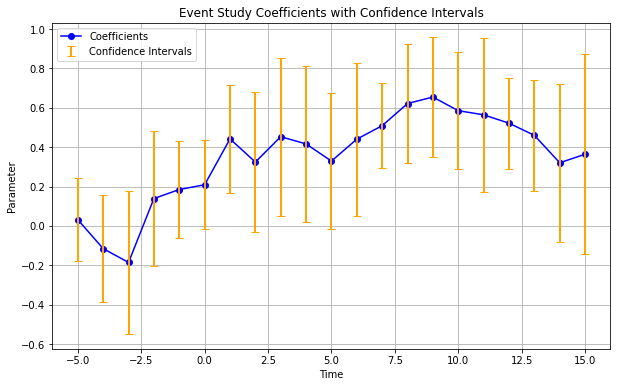

In [24]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Plot coefficients as points
plt.plot(summary_table['Time'], summary_table["Parameter"], 'o-', label='Coefficients', color='b')

# Plot confidence intervals as error bars
plt.errorbar(summary_table['Time'], summary_table["Parameter"],
             yerr=[summary_table["Parameter"] - summary_table['Lower CI'],
                   summary_table['Upper CI'] - summary_table["Parameter"]],
             fmt='none', ecolor='orange', elinewidth=2, capsize=4, label='Confidence Intervals')

plt.xlabel('Time')
plt.ylabel("Parameter")
plt.title('Event Study Coefficients with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()